# Fragment library analysis: Comparison to literature

## Aim of this notebook

This notebook aims to load kinase inhibitor fragment data from literature and check if these fragments are included in our fragment library.

**This notebook is still work-in-progress.** This analysis has been done visually by hand before and shall now be set up computationally here (in addition).

In [1]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools

from utils import read_fragment_library, draw_fragmented_ligand

In [2]:
PATH_DATA = Path('.') / '..' / 'data'

## Load fragment library

`fragment_library` is a dictionary containing a `pandas` DataFrame for each of the six subpockets (AP, FP, SE, GA, B1, B2) and the pool X.

The following data is linked to each fragment:

- `ROMol`, `ROMol_dummy`, and `ROMol_original`: RDKit molecules for the 2D representation of the fragment without and with dummy atoms as well as for the 3D representation of the fragment as described in the SDF file from which the data is loaded.
- `kinase`, `family`, and `group`: *Kinase* name, *family* and *group* of the kinase that the ligand (from which the fragment originates) was co-crystallized with
- `complex_pdb`, `ligand_pdb`, `alt`, and `chain`: *PDB complex* and *ligand ID*, *alternate model* and *chain* for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- `atom_subpockets`: Subpocket assignment for each of the fragment's atoms
- `atom_environments`: BRICS environment IDs for each of the fragment's atoms
- `smiles` and `smiles_dummy`: SMILES for the fragment without and with dummy atoms
- `subpocket`: Subpocket assignment for the fragment

In [3]:
# Get fragment library by subpocket
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')

## Load original ligands

(2553, 12)


,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi,ROMol
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...,
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...,

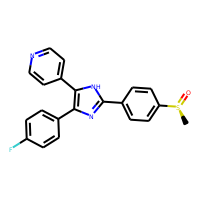
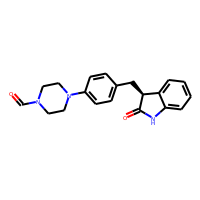

In [4]:
original_ligands = pd.read_json(PATH_DATA / 'fragment_library' / 'original_ligands.json')
PandasTools.AddMoleculeColumnToFrame(original_ligands, 'smiles')

print(original_ligands.shape)
original_ligands.head(2)

## Yang et al. 2019

### Publication

[In Silico Design and Analysis of a Kinase-Focused Combinatorial Library Considering Diversity and Quality](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00841)

Abstract:
> A structurally diverse, high-quality, and kinase-focused database plays a critical role in finding hits or leads in kinase drug discovery. Here, we propose a workflow for designing a virtual kinase-focused combinatorial library using existing structures. Based on the analysis of known protein kinase inhibitors (PKIs), detailed fragment optimization, fragment selection, fragment linking, and a molecular filtering scheme were defined. Quick recognition of core fragments that can possibly form dual hydrogen bonds with the hinge region of the ATP-pocket was proposed. Furthermore, three diversity and four quality metrics were chosen for compound library analysis, which can be applied to databases with over 30 million structures. Compared with 13 commercial libraries, our protocol demonstrates a special advantage in terms of good skeleton diversity, acceptable fingerprint diversity, balanced scaffold distribution, and high quality, which can work well not only on existing PKIs, but also on four chosen commercial libraries. Overall, the strategy can greatly facilitate the expansion of a desirable chemical space for kinase drug discovery.

### Comparison of core fragments with our AP fragments

**Core fragments from Yang et al. publication (only largest core fragments so far)**

,smiles,ROMol
0,C3=C2C(=O)N(C1(CCCCC1)N2C(C=C3)=O)[H],
1,C13=C(CCC2=CN=CN=C12)C=N[NH]3,

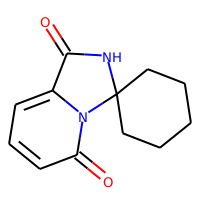
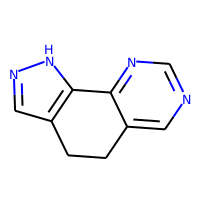

In [5]:
yang_mols = pd.DataFrame(
    [
        'C3=C2C(=O)N(C1(CCCCC1)N2C(C=C3)=O)[H]',
        'C13=C(CCC2=CN=CN=C12)C=N[NH]3'
    ],
    columns=['smiles']
)
PandasTools.AddMoleculeColumnToFrame(yang_mols, 'smiles')
yang_mols

**Are these molecules part of our original ligands?**

In [6]:
matches = {}

for i, mol in yang_mols.iterrows():
    matches[i] = []
    
    try:
        for j, original_ligand in original_ligands.iterrows():
            
            template = original_ligand.ROMol
            pattern = mol.ROMol
            match = template.HasSubstructMatch(pattern)
            if match:
                matches[i].append(original_ligand)
        
    except AttributeError:  # ROMol missing
        print(f'Original ligand {j} has no ROMol.')
        
    matches[i] = pd.concat(matches[i], axis=1).transpose()

,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi,ROMol
2294,6ck6,N45,"[AP, FP]",MNK2,MAPKAPK,CAMK,,A,out-like,Cc1cc(Nc2cc(N)ncn2)c(=O)n2c1C(=O)NC21CCCCC1,InChI=1S/C17H20N6O2/c1-10-7-11(21-13-8-12(18)1...,

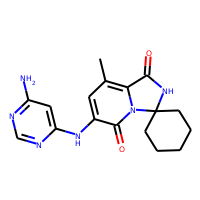

In [7]:
matches[0]

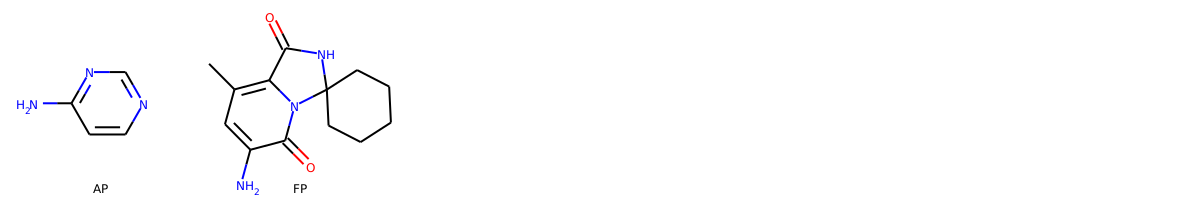

In [8]:
draw_fragmented_ligand(fragment_library, '6ck6', 'N45')

,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi,ROMol
341,2wip,P49,"[AP, SE, GA]",CDK2,CDK,CMGC,,C,in,Cn1nc(C(=O)[O-])c2c1-c1nc(Nc3ccccc3)ncc1CC2,InChI=1S/C17H15N5O2/c1-22-15-12(14(21-22)16(23...,
376,2x9e,SVE,"[AP, FP, SE, X]",TTK,TTK,Other,,A,in,CCc1cccc(CC)c1NC(=O)c1nn(C)c2c1CCc1cnc(Nc3ccc(...,InChI=1S/C35H39F3N8O3/c1-5-20-8-7-9-21(6-2)28(...,

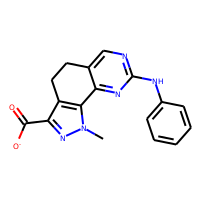
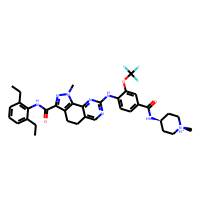

In [9]:
matches[1].head(2)

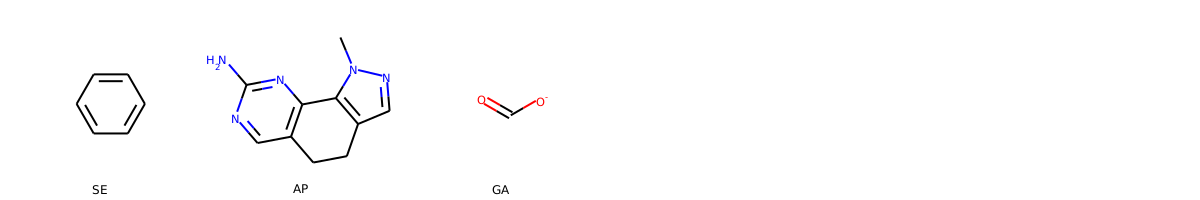

In [10]:
draw_fragmented_ligand(fragment_library, '2wip', 'P49')